# Solving Ehrenfest Diffusion with Markov Chains

This excersize covers the problem put forward by the famous physicist and one of the fathers of statistical mechanics. We will learn how to formulate a problem in terms of specific states and calculate probabilities based on the Markov property. We will in particular:
1. Compute probabilities based on matrix operations.
2. Compare the computed results with simple simulations.

The exercise is made to play around with a simple thought experiment and combine calculations with direct simulations. This is not curriculum, but can turn in valuable for your future careers. 

### References:
- Lecture on Markov Chains

### Authors: 
- Mathias L. Heltberg (Niels Bohr Institute)

### Date:    
- 29-12-2021 (latest update)

***

As always we will include a collection of libraries (Standard)

In [140]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
from numpy.linalg import matrix_power                  # This is to raise matrices to powers
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Module to see files and folders in directories
from scipy import stats

Naturally we will here need a random generator:

In [141]:
r = np.random # Random generator
r.seed(42)    # Set a random seed (but a fixed one)

And now for the actual problem: We have two baskets, a blue and a red. We have 10 balls, and each turn we pick a random ball and move it from the basket it is in, over to the other basket.

**We want to compute the probability that there are 7 balls in the blue basket after 20 turns, given that 3 balls are in the blue container in the beginning.**

This assignment is tricky, since the probability must be affected by the number of balls after 19 turns, and this is affected by the situation after 18 turns etc.

Therefore we start by simulating the situation:

In [142]:
NB = 10; ### This is the number of balls - note the number of states is NB+1. Do you understand why?
Initial_Place = np.zeros((NB,), dtype=int)
Initial_Place[3:] = 1; ### Make initial distribution
print(Initial_Place)

[0 0 0 1 1 1 1 1 1 1]


Now we have the initial setting in place. We next simulate the 20 turns:

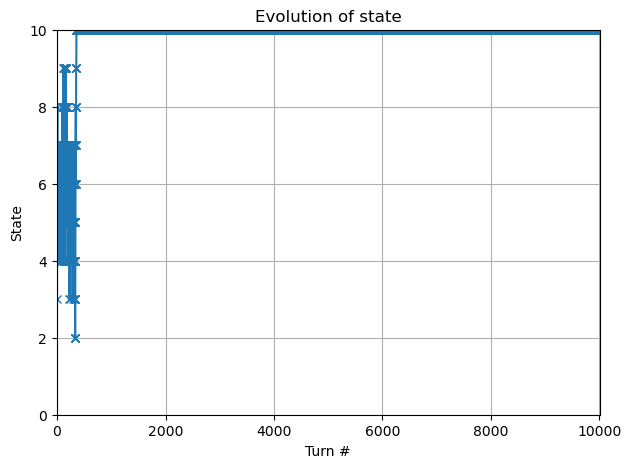

In [143]:
ntest = 100 ### Number of times we perform the experiment - this can be changed
nturns = 10000 ### The 20 turns we pick the balls
H20 = np.zeros(ntest)
turnsTo10 = np.zeros(ntest)
for itest in range(ntest):
    Place = Initial_Place.copy()
    Nballs = np.zeros(nturns+1) ### Here we count the number of balls in the blue basket (i.e. basket #0)
    Nballs[0] = np.sum(Place==0)
    for iturns in range(nturns):
        coin = r.randint(0,2) ### Generates a random integer between 0 and 1 (i.e. 0 or 1)
        id = np.random.randint(0,10) ### Generates an integer between 0 and 10             
        if (Place[id] == 0) and (coin == 0):
            Place[id] = 1
        elif (coin == 0):
            Place[id] = 0
        Nballs[iturns +1] = np.sum(Place==0)
        if (np.sum(Place==0) == 10):
            Nballs[iturns +1:] = np.sum(Place==0)
            turnsTo10[itest] = iturns
            break

    
    if (itest == 0):
        fig = plt.figure(figsize=[7,5])
        ax = plt.subplot(111)
        ax.plot(np.arange(0,nturns+1,1), Nballs,'-x')
        ax.set_xlabel('Turn #')
        ax.set_ylabel('State')
        ax.set_title('Evolution of state')

        # set the limits
        ax.set_xlim(0, nturns + 1)
        ax.set_ylim(0, 10)

        # set the grid on
        ax.grid('on')
    H20[itest] = np.sum(Place==0)
    


2117.92

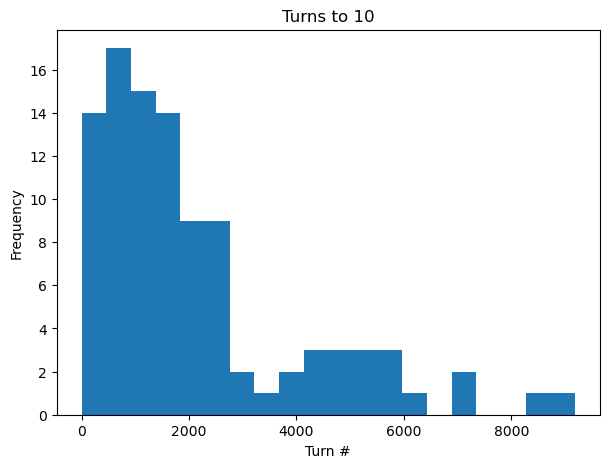

In [144]:
#Plot turnTo10
fig = plt.figure(figsize=[7,5])
ax = plt.subplot(111)
ax.hist(turnsTo10, bins=20)
ax.set_xlabel('Turn #')
ax.set_ylabel('Frequency')
ax.set_title('Turns to 10')
np.mean(turnsTo10)

So far we have plotted one realization of the ball swapping experiment. Lets us plot the distribution after 20 turns...

98


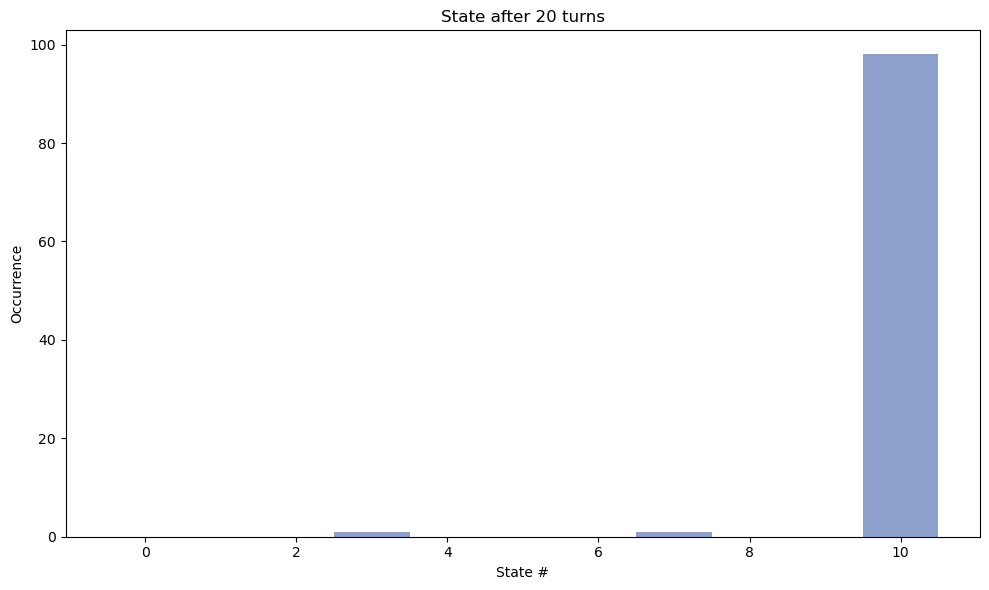

In [145]:
plt.figure(figsize=(10,6), tight_layout=True)
bins = np.arange(-0.5,11.5,1)
# matplotlib
plt.hist(H20, bins=bins, color=sns.color_palette('Set2')[2], linewidth=4)
plt.title('State after 20 turns')
plt.xlabel('State #')
plt.ylabel('Occurrence')
#print(H20)
print(np.sum(H20 == 10))

So far for the simulations. We now go to the derivations based on the Markov Chain formulation. We construct the matrix of jump probabilities. It can be constructed by:

In [146]:
M = np.zeros((NB+1,NB+1))
for i in range(NB+1):
    if (i==0):
        M[i,i+1] = (NB-i)/NB
    elif (i==NB):
        M[i,i-1] = i/NB
    else:
        M[i,i-1] = i/NB
        M[i,i+1] = (NB-i)/NB

#print(M)

M2 = 0.5 * (M + np.diag(np.ones(NB+1)))

print(M2)

M3 = np.zeros((NB+1,NB+1))
for i in range(NB+1):
    if (i==0):
        M3[i,i+1] = 0.5*(NB-i)/NB
        M3[i,i] = 0.5
    elif (i==NB):
        M3[i,i] = 1
    else:
        M3[i,i-1] = 0.5*i/NB
        M3[i,i+1] = 0.5*(NB-i)/NB
        M3[i,i] = 0.5

#print(M3)

[[0.5  0.5  0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.05 0.5  0.45 0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.1  0.5  0.4  0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.15 0.5  0.35 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.2  0.5  0.3  0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.25 0.5  0.25 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.3  0.5  0.2  0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.35 0.5  0.15 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.4  0.5  0.1  0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.45 0.5  0.05]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.5  0.5 ]]


Based on this matrix, we want to compute the probabilities of being in the different states. This is what we do here:

In [147]:
V1 = np.zeros((1,NB+1)); V1[0,3] = 1; ### Note V1 represents the initial probability of states (all is in state 3)
V2 = np.zeros(NB+1); V2[10] = 1 ### Note V2 represents the outcome probability (Here we are interested in state 9)
print('Probability of initial state is:',V1)

PAfter = np.matmul(V1,matrix_power(M3,nturns)) #### Insert your calculations here!!!##########
P9 = np.matmul(PAfter,V2) #### Insert your calculations here!!! #############
print('The probability array after n swappings is: ',PAfter)
print('The probability of ending up in state 9 after 20 swappings is: ',*P9*100,'%')

Probability of initial state is: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
The probability array after n swappings is:  [[1.40451874e-05 1.40332170e-04 6.30836901e-04 1.68000099e-03
  2.93474910e-03 3.51249436e-03 2.91441878e-03 1.65098242e-03
  6.04759765e-04 1.21055126e-04 9.85796325e-01]]
The probability of ending up in state 9 after 20 swappings is:  98.57963252010683 %


Text(0.5, 1.0, 'Probability of ending up in state 10')

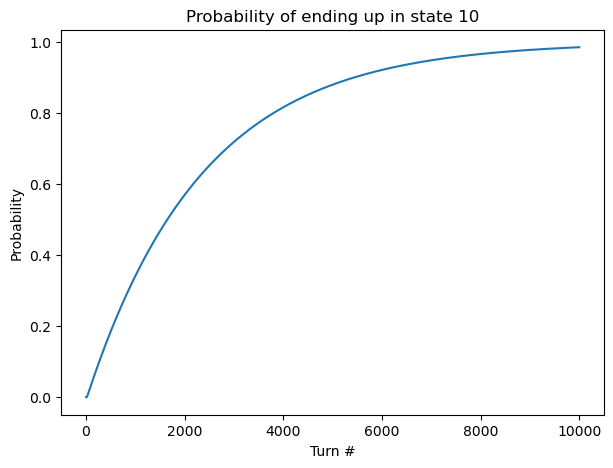

In [152]:
# make cdf for the distribution with absorbing state
percent10 = np.zeros(nturns)
for i in range(nturns):
    percent10[i] = np.matmul(np.matmul(V1,matrix_power(M3,i)),V2)

#plot percent10
fig = plt.figure(figsize=[7,5])
ax = plt.subplot(111)
ax.plot(np.arange(0,nturns,1), percent10,'-')
ax.set_xlabel('Turn #')
ax.set_ylabel('Probability')
ax.set_title('Probability of ending up in state 10')

Text(0.5, 1.0, 'Probability of ending up in state 10')

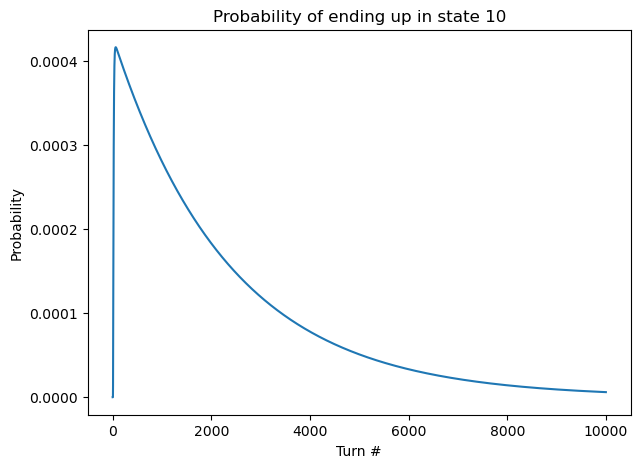

In [154]:
#from the cdf find pdf
pdf10 = np.diff(percent10)

#Plot pdf10
fig = plt.figure(figsize=[7,5])
ax = plt.subplot(111)
ax.plot(np.arange(0,nturns-1,1), pdf10,'-')
ax.set_xlabel('Turn #')
ax.set_ylabel('Probability')
ax.set_title('Probability of ending up in state 10')
 

# Questions:

This exercise is made to understand and simulate a simple thought experiment, where the calculations can easily be very tedious. The questions here aims at understanding the results and playing with the system:

1) Start by looking at the matrix M. Do you understand why it has the shape it does? What is the probability to have 9 balls in the blue basked (basket #0) after 21 turns? Why is this?

The probablity should be 0, since we take an odd number of turns, meaning the distribution should result in an even number of balls in the blue basket.

2) Rewrite the system so at each turn there is a 50% chance of nothing happens (ie no ball is moved). How does this affect the probabilities? Can all states be reached after 20 turns?
All states can be reached, but the probabilities are much more skewed towards states with low number of balls due to the low number of turns. 

3) Change the number of turns to something much larger (try 1000). What value is the most probable to reach? Does this make sense?
5 is the most probable, wich makes sense. The probablility is also symmetrical around 5. 

### Advanced question:

4) Assume that the state #10 (where all balls are blue) is an absorbing state, so nothing changes after this state is reached. What is the average number of turns to reach this? Can you find a PDF that fits the distribution of first passage times?

After 1000 turns the probability is 34%. This is consistent with simulation, where we get 346 out of 1000. 
About 2117 turns are needed to reach the absorbing state on average. This is using 10000 turns, which should be enough for 98.5 of the experiments to reach the absorbing state.

5) Assume that the initial position of the balls is not always three blue, but instead a poissonian distribution with mean=1. How does this change the distribution to reach state 10? Can you fit this distribution?

# Learning points

This is simple introduction of the application of Markov Chains and their use in calculations on simple probability questions.

What is important in this, is that all probabilities at a specific state, depends completely on the last state etc. This makes all calculations iterative and this is almost impossible from "standard" frequentist approaches. The construction of a Transfer matrix simplifies such calculations enormously and it is hoped you will appreciate this.

From this exercise, you should have learned:

1) How to calculate probabilities in a problem, where measurements are not independent and the (n+1)'th state is based on the n'th state. 

2) How to construct a transfer matrix based on a simple setup.

3) Understand why an equlibrium state is reached and how one can use a probability distribution in the first state to calculate a probability in the n'th state.